In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

2025-05-21 00:04:06.719748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747785846.921796      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747785846.983070      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# -------------------------------------------
# 2. Basic Settings and Data Paths
# -------------------------------------------
dataset_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "valid")
batch_size = 32
img_size = 224
epochs = 5

In [3]:
# -------------------------------------------
# 3. Data Preparation and Generation
# -------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [4]:
# -------------------------------------------
# 4. Build Inception-ResNet-V2 Model
# -------------------------------------------
def build_inception_model():
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
        
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [5]:
# Train Inception-ResNet-V2
inception_model = build_inception_model()
print("\n--- Training Inception-ResNet-V2 Model ---")
history_inception = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,  
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)

I0000 00:00:1747785881.606197      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747785881.606851      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Training Inception-ResNet-V2 Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1747786020.028357      77 service.cc:148] XLA service 0x7eb290003bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747786020.029147      77 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747786020.029170      77 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747786033.231098      77 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747786082.449751      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1560s 622ms/step - accuracy: 0.8059 - loss: 0.7408 - val_accuracy: 0.9703 - val_loss: 0.1317
Epoch 2/5
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 21:59 601ms/step - accuracy: 1.0000 - loss: 0.0144

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 0.9689 - val_loss: 0.1316
Epoch 3/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1289s 587ms/step - accuracy: 0.9766 - loss: 0.0769 - val_accuracy: 0.9814 - val_loss: 0.0861
Epoch 4/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.9688 - loss: 0.1458 - val_accuracy: 0.9817 - val_loss: 0.0858
Epoch 5/5
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1289s 587ms/step - accuracy: 0.9838 - loss: 0.0544 - val_accuracy: 0.9892 - val_loss: 0.0371



=== Evaluating InceptionResNetV2 Model ===

Evaluating Inception-ResNet-V2 Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 89s 161ms/step - accuracy: 0.9910 - loss: 0.0297

Model InceptionResNetV2 Test Accuracy: 0.9892, Test Loss: 0.0371
550/550 ━━━━━━━━━━━━━━━━━━━━ 108s 172ms/step

Detailed Classification Report for InceptionResNetV2:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      0.99      1.00       440
                                   Apple___healthy       1.00      0.97      0.98       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(i

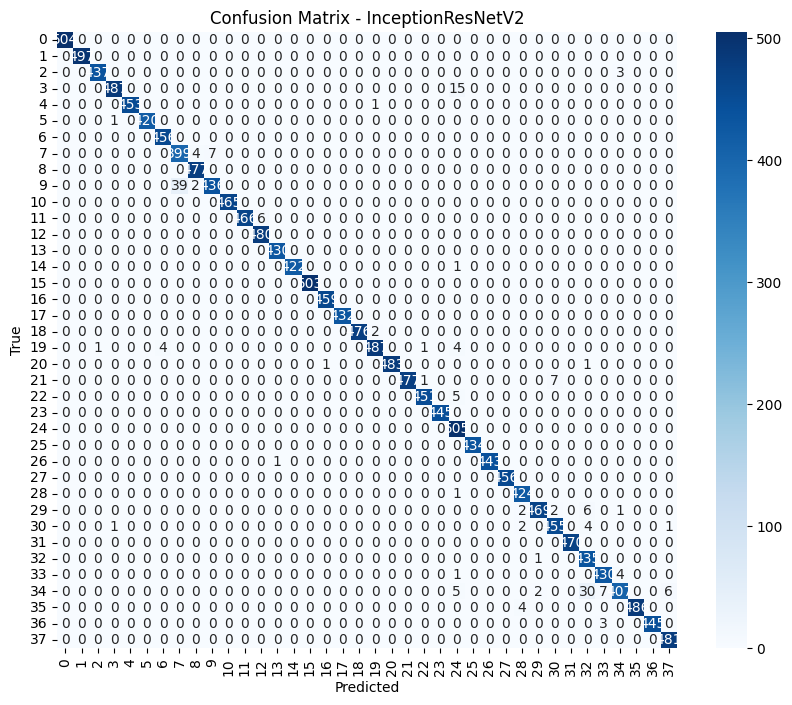

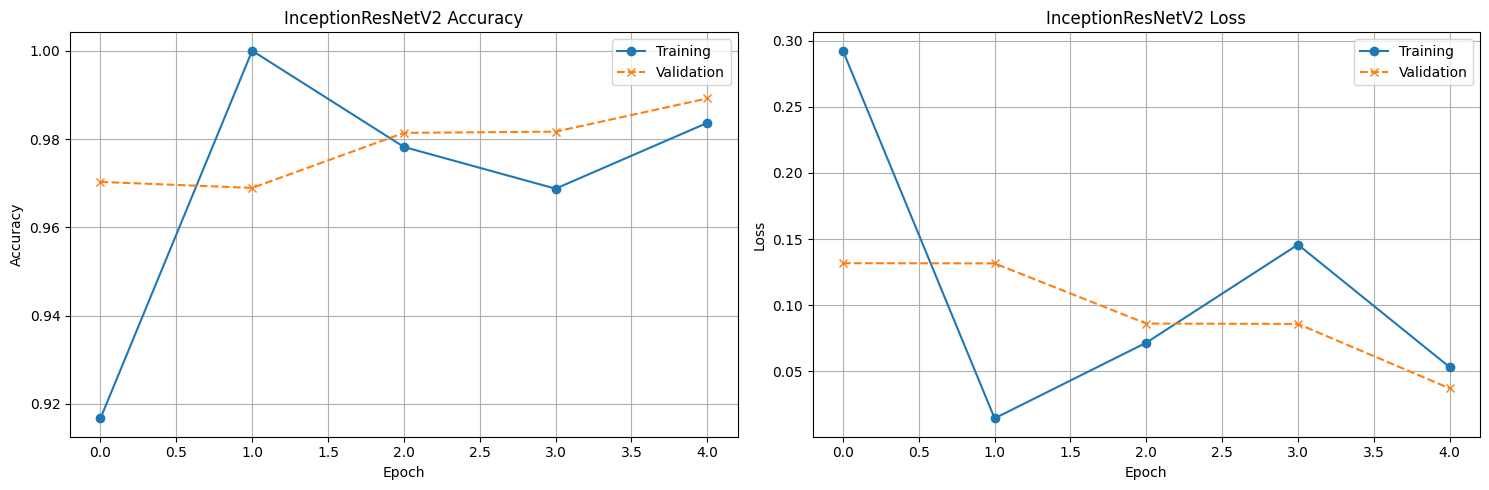


Model Results:
               Model  Test Accuracy  Test Loss
0  InceptionResNetV2       0.989187   0.037079
Results saved as 'model_results.csv'


In [6]:
# -------------------------------------------
# 5. Evaluation Functions
# -------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# List to store evaluation results
results = []

def evaluate_model(model, history, model_name, test_generator):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'\nModel {model_name} Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')
    
    # Store results
    results.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Test Loss': test_loss
    })
    
    # Predictions and classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(test_generator.classes, y_pred_classes,
                                target_names=list(test_generator.class_indices.keys())))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(test_generator.classes, y_pred_classes), 
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    plt.close()
    
    return history, test_acc, test_loss

def plot_metrics(history, model_name):
    plt.figure(figsize=(15, 5))
    
    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], marker='o', label='Training')
    plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], marker='o', label='Training')
    plt.plot(history.history['val_loss'], marker='x', linestyle='--', label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_metrics.png')
    plt.show()
    plt.close()

def save_results(results):
    df = pd.DataFrame(results)
    df.to_csv('model_results.csv', index=False)
    print("\nModel Results:")
    print(df)
    print("Results saved as 'model_results.csv'")

# -------------------------------------------
# 6. Execute Evaluation
# -------------------------------------------
print("\n=== Evaluating InceptionResNetV2 Model ===")

# Evaluate InceptionResNetV2
print("\nEvaluating Inception-ResNet-V2 Model...")
history_inception, inception_acc, inception_loss = evaluate_model(
    inception_model, 
    history_inception, 
    "InceptionResNetV2", 
    test_generator
)

# Plot metrics
plot_metrics(history_inception, "InceptionResNetV2")

# Save results
save_results(results)

In [7]:
# -------------------------------------------
# 7. Save Models
# -------------------------------------------
os.makedirs('saved_models', exist_ok=True)

inception_model.save('saved_models/Plant disease discovery_InceptionResNetV2_5_epochs.h5')
print("Inception-ResNet-V2 Model saved at: saved_models/Plant disease discovery_InceptionResNetV2_5_epochs")

Inception-ResNet-V2 Model saved at: saved_models/Plant disease discovery_InceptionResNetV2_5_epochs
